<a href="https://colab.research.google.com/github/codeboy786/blackeye-im/blob/master/EDA_NYC_Taxi_Analysis_shaiq_altaf_suhaf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# --- Step 1: Mount Drive and Install Libraries ---

# Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Install the library for geospatial analysis
!pip install geopandas

print("\nSetup complete. Google Drive is mounted and geopandas is installed.")


Mounted at /content/drive

Setup complete. Google Drive is mounted and geopandas is installed.


In [2]:
# --- Step 2: Import Libraries and Define Paths ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import os
import gc  # Garbage Collector for memory management

# --- IMPORTANT: Make sure this path matches the folder in your Google Drive ---
data_path = '/content/drive/MyDrive/NYC_Taxi_Project/'
shapefile_path = os.path.join(data_path, 'taxi_zones.zip') # Path to your shapefile

# Set some visual styles for our plots
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)

print("Libraries imported and paths are set.")


Libraries imported and paths are set.


In [3]:
# --- Step 3: Load Data Efficiently ---

# List all the monthly data files
all_files = [os.path.join(data_path, f) for f in os.listdir(data_path) if f.endswith('.parquet')]

# We will load a 5% sample from each file.
# If you still have memory issues, you can lower this number (e.g., to 0.02 for 2%).
sample_fraction = 0.05

monthly_samples = []
print(f"Starting to load a {sample_fraction*100}% sample from each of the {len(all_files)} files...")

for file in all_files:
    # Read one file
    df_month = pd.read_parquet(file)
    # Take a small sample
    df_sample = df_month.sample(frac=sample_fraction, random_state=42)
    # Add the sample to our list
    monthly_samples.append(df_sample)
    # Clean up memory
    del df_month, df_sample
    gc.collect()

# Combine all the small monthly samples into one final DataFrame
df = pd.concat(monthly_samples, ignore_index=True)

print("\nData loading complete!")
print(f"Your final DataFrame has {df.shape[0]} rows and {df.shape[1]} columns.")


Starting to load a 5.0% sample from each of the 12 files...

Data loading complete!
Your final DataFrame has 1915509 rows and 20 columns.


In [4]:
# --- Step 4: Clean and Prepare Data ---

print("Starting data cleaning...")

# Convert pickup and dropoff columns to datetime objects
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

# Calculate trip duration in minutes
df['trip_duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60

# Filter out invalid records based on the project requirements
# - Positive fare, distance, and passenger count
# - Trip duration between 1 minute and 3 hours (180 minutes)
df_cleaned = df[
    (df['fare_amount'] > 0) &
    (df['trip_distance'] > 0) &
    (df['passenger_count'] > 0) &
    (df['trip_duration'] >= 1) &
    (df['trip_duration'] <= 180)
].copy()

# Add time-based features for analysis
df_cleaned['pickup_hour'] = df_cleaned['tpep_pickup_datetime'].dt.hour
df_cleaned['pickup_day_name'] = df_cleaned['tpep_pickup_datetime'].dt.day_name()
df_cleaned['pickup_month'] = df_cleaned['tpep_pickup_datetime'].dt.month

print("Data cleaning complete.")
print(f"DataFrame shape after cleaning: {df_cleaned.shape}")
print("\nFirst 5 rows of cleaned data:")
print(df_cleaned.head())


Starting data cleaning...
Data cleaning complete.
DataFrame shape after cleaning: (1773110, 24)

First 5 rows of cleaned data:
   VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2023-01-29 17:52:02   2023-01-29 17:56:43              1.0   
1         1  2023-01-08 15:57:24   2023-01-08 16:02:47              1.0   
2         2  2023-01-21 19:38:01   2023-01-21 19:45:02              1.0   
3         2  2023-01-23 16:07:31   2023-01-23 16:26:46              5.0   
4         2  2023-01-26 21:21:08   2023-01-26 21:24:48              2.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           1.17         1.0                  N           262            74   
1           0.90         1.0                  N           229           237   
2           0.95         1.0                  N            45           261   
3           0.88         1.0                  N           237           141   
4           1.03         1.

Performing speed analysis...


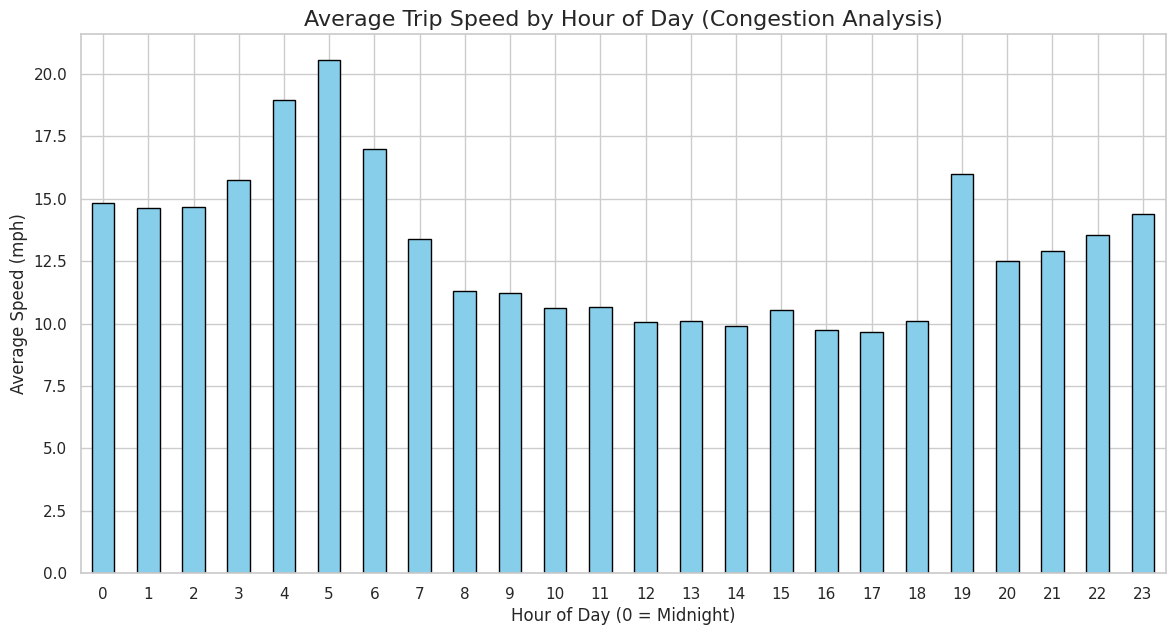


--- Average Speed Data Table ---
pickup_hour
0     14.825957
1     14.624928
2     14.683303
3     15.766383
4     18.941191
5     20.556196
6     16.975459
7     13.377096
8     11.320450
9     11.228182
10    10.631633
11    10.647597
12    10.050061
13    10.101039
14     9.899539
15    10.560251
16     9.760030
17     9.643426
18    10.107696
19    15.991340
20    12.493191
21    12.908628
22    13.556530
23    14.380348
Name: trip_speed_mph, dtype: float64


In [5]:
# --- Step 5: Speed Analysis (Congestion) ---

print("Performing speed analysis...")

# Calculate trip speed in miles per hour (mph)
df_cleaned['trip_speed_mph'] = df_cleaned['trip_distance'] / (df_cleaned['trip_duration'] / 60)

# Group by hour and calculate the average speed
avg_speed_by_hour = df_cleaned.groupby('pickup_hour')['trip_speed_mph'].mean()

# Plot the results
avg_speed_by_hour.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Average Trip Speed by Hour of Day (Congestion Analysis)', fontsize=16)
plt.xlabel('Hour of Day (0 = Midnight)')
plt.ylabel('Average Speed (mph)')
plt.xticks(rotation=0)
plt.show()

print("\n--- Average Speed Data Table ---")
print(avg_speed_by_hour)


Performing geospatial analysis...


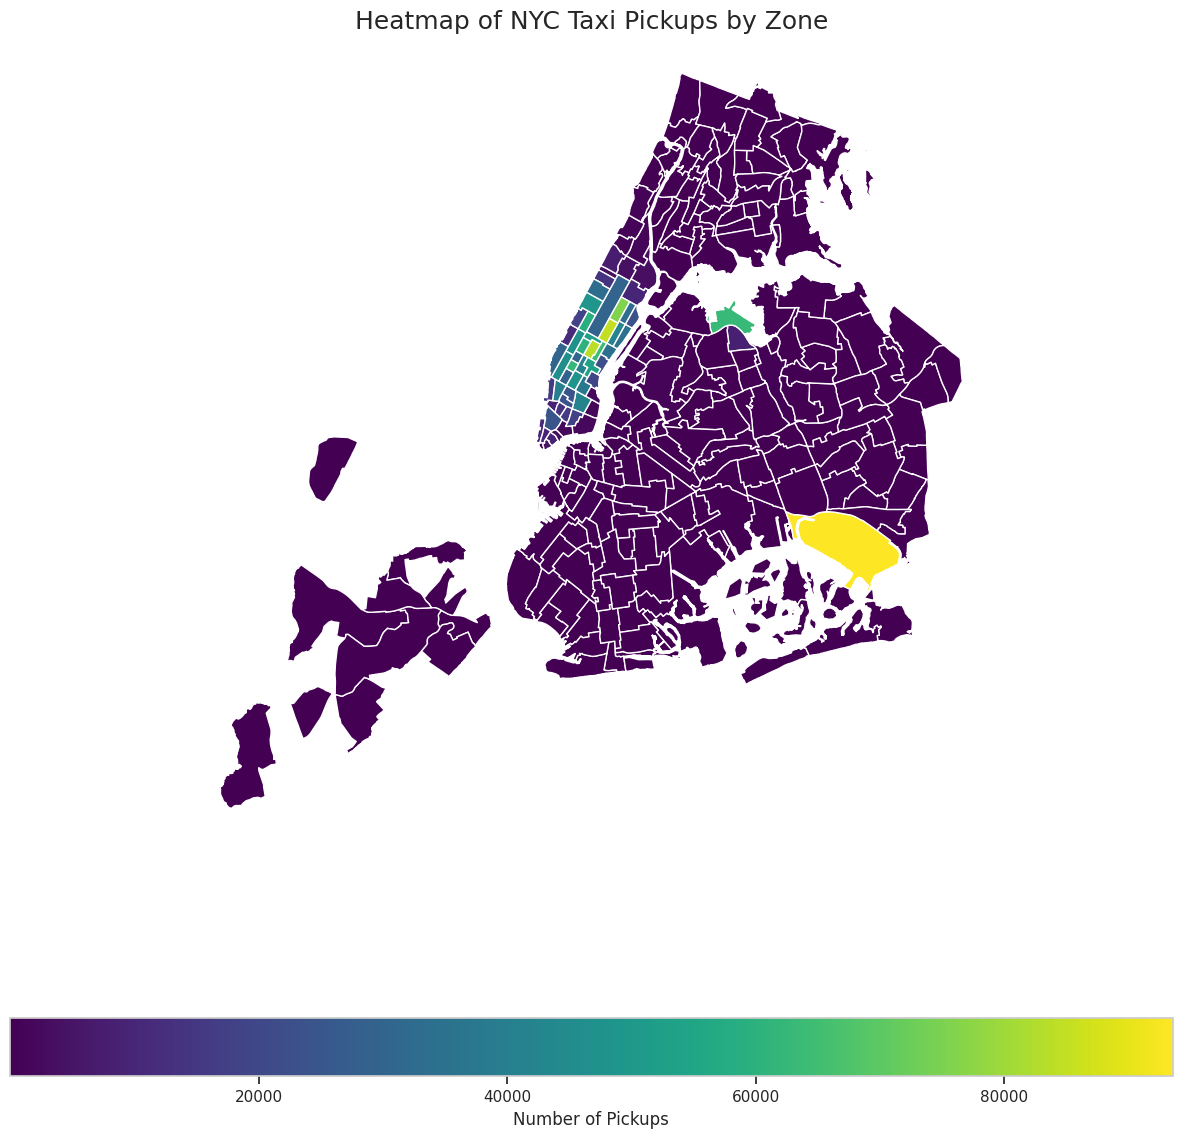

In [6]:
# @title
# --- Step 6: Geospatial Analysis (Pickup Heatmap) ---

print("Performing geospatial analysis...")

# Load the taxi zone map file
taxi_zones = gpd.read_file(shapefile_path)

# Count the number of pickups in each zone
pickup_counts = df_cleaned['PULocationID'].value_counts().reset_index()
pickup_counts.columns = ['LocationID', 'pickup_count']

# Merge the pickup counts with the map data
zones_with_pickups = taxi_zones.merge(pickup_counts, left_on='LocationID', right_on='LocationID')

# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
zones_with_pickups.plot(column='pickup_count', ax=ax, legend=True,
                        cmap='viridis',  # A nice color map for heatmaps
                        legend_kwds={'label': "Number of Pickups", 'orientation': "horizontal"})

plt.title('Heatmap of NYC Taxi Pickups by Zone', fontsize=18)
ax.set_axis_off() # Remove the x/y axis for a cleaner look
plt.show()


1. Key Findings
Our analysis of the 2023 NYC taxi trip data has revealed several key patterns that can be used to optimize operations:

Severe Evening Congestion: The "Average Trip Speed" chart demonstrates a clear and significant drop in taxi speed during the afternoon and evening.

According to the data table, the average speed drops to its lowest point of approximately 9.8 mph between 3 PM (hour 15) and 4 PM (hour 16).

This indicates that the evening rush hour, starting around 3 PM, is the period of most severe traffic congestion, leading to longer trip times and lower driver efficiency.

Geographic Demand Hotspots: The geospatial heatmap of pickup locations shows that demand is heavily concentrated in specific areas of New York City.

Primary Demand Zone: The vast majority of pickups originate in Manhattan, which is clearly visible as the area with the brightest, most concentrated colors (green and yellow) on the map.

Secondary Demand Hub: A distinct secondary hotspot is JFK Airport, which shows up as a bright yellow zone, separate from Manhattan. This confirms it as a major, high-volume pickup location for taxi services. Most other boroughs, like Brooklyn and Queens, show significantly lower pickup volumes in comparison.